---
title: Assignment 04
author:
  - name: Dominique Strong
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: today
date-modified: today
date-format: long
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2

execute:
  echo: false
  eval: false
  freeze: auto
---

In [40]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("/home/ubuntu/assignment-03-DomStrong11/data/lightcast_job_postings.csv")
# The data is not available in assignment-04 folder, so I used the full path to the data file.


# Show Schema and Sample Data
#print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
#df.show(5)

Feature Engineering & Column Selection

In [41]:
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

eda_cols = [
    "SALARY",
    "MIN_YEARS_EXPERIENCE",
    "MAX_YEARS_EXPERIENCE",
    "DURATION",
    "STATE_NAME",
    "CITY_NAME",
    "REMOTE_TYPE_NAME",
    "EMPLOYMENT_TYPE_NAME",
    "IS_INTERNSHIP",
    "COMPANY_IS_STAFFING",
    "MIN_EDULEVELS_NAME",
]

#df_eda = df.select(eda_cols)
#df_eda.show(5, truncate=False)

In [42]:
from pyspark.sql.functions import col, sum as spark_sum, when, trim, length
import hvplot.pandas

missing_df = df_eda.select([
    spark_sum(
        when(col(c).isNull() | (length(trim(col(c))) == 0), 1).otherwise(0)).alias(c)
     for c in df_eda.columns
])

missing_pd = missing_df.toPandas().T.reset_index()
missing_pd.columns = ["column", "missing_count"]

total_rows = df_eda.count()
missing_pd["missing_pct"] = 100 * missing_pd["missing_count"] / total_rows

missing_pd.sort_values(by="missing_pct", ascending=False).hvplot.bar(
    x="column",
    y="missing_pct",
    title="Percentage of Missing Values by Column",
    rot=60,
    height=500,
    width=900,
    ylabel="Missing Percentage (%)",
    xlabel="Features"
).opts(xrotation=45)

:Bars   [column]   (missing_pct)

Max years of experience and Salary are the only columns with null values

In [ ]:
# Cleaning multiple columns for potential use in the models
# Cleaning the Remote Type Name Column

df_eda = df_eda.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

categorical_cols = ["REMOTE_TYPE_NAME"]

for colname in categorical_cols:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----REMOTE_TYPE_NAME -----


+----------------+
|REMOTE_TYPE_NAME|
+----------------+
|Remote          |
|On Premise      |
|Hybrid          |
|Undefined       |
+----------------+



In [44]:
# Cleaning the State Name Column

cat_state_cols = ["STATE_NAME"]

for colname in cat_state_cols:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----STATE_NAME -----


+---------------------------------------+
|STATE_NAME                             |
+---------------------------------------+
|Utah                                   |
|Hawaii                                 |
|Minnesota                              |
|Ohio                                   |
|Arkansas                               |
|Oregon                                 |
|Texas                                  |
|North Dakota                           |
|Pennsylvania                           |
|Connecticut                            |
|Nebraska                               |
|Vermont                                |
|Nevada                                 |
|Washington                             |
|Illinois                               |
|Oklahoma                               |
|Delaware                               |
|Alaska                                 |
|New Mexico                             |
|West Virginia                          |
|Missouri                         

In [45]:
# Cleaning the Employee Type Name Column

df_eda = df_eda.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME") == "Part-time / full-time", "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Part-time (â‰¤ 32 hours)", "Parttime")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Full-time (> 32 hours)", "Fulltime")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Fulltime")
    .otherwise(col("EMPLOYMENT_TYPE_NAME"))
)

categorical_cols_emp = ["EMPLOYMENT_TYPE_NAME"]

for colname in categorical_cols_emp:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----EMPLOYMENT_TYPE_NAME -----


+--------------------+
|EMPLOYMENT_TYPE_NAME|
+--------------------+
|Flexible            |
|Fulltime            |
|Parttime            |
+--------------------+



In [46]:
# Cleaning the Company Is Staffing Column

df_eda = df_eda.withColumn(
    "COMPANY_IS_STAFFING",
    when(col("COMPANY_IS_STAFFING").isNull(), False)
    .otherwise(col("COMPANY_IS_STAFFING"))
)

categorical_cols_staff = ["COMPANY_IS_STAFFING"]

for colname in categorical_cols_staff:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----COMPANY_IS_STAFFING -----


+-------------------+
|COMPANY_IS_STAFFING|
+-------------------+
|true               |
|false              |
+-------------------+



In [47]:
# Cleaning the IS Internship Column

df_eda = df_eda.withColumn(
    "IS_INTERNSHIP",
    when(col("IS_INTERNSHIP").isNull(), False)
    .otherwise(col("IS_INTERNSHIP"))
)

categorical_cols_intern = ["IS_INTERNSHIP"]

for colname in categorical_cols_intern:
    print(f'\n----{colname} -----')
    df_eda.select(colname).distinct().show(50, truncate=False)


----IS_INTERNSHIP -----


+-------------+
|IS_INTERNSHIP|
+-------------+
|true         |
|false        |
+-------------+



In [48]:
from pyspark.sql import functions as F

# Replace missing durations with the median
# Calculate the median duration
# Replace missing experience values with the median
# Calculate the median experience

df_eda = df_eda.withColumn("DURATION", F.col("DURATION").cast("double")) \
               .withColumn("MAX_YEARS_EXPERIENCE", F.col("MAX_YEARS_EXPERIENCE").cast("double")) \

median_duration = df.approxQuantile("DURATION", [0.5], 0.01)[0]
median_exp = df.approxQuantile("MAX_YEARS_EXPERIENCE", [0.5], 0.01)[0]

df_eda = df_eda.withColumn(
    "DURATION",
    F.when(F.col("DURATION").isNull() | F.isnan("DURATION"), F.lit(median_duration))
     .otherwise(F.col("DURATION"))
).withColumn(
    "MAX_YEARS_EXPERIENCE",
    F.when(F.col("MAX_YEARS_EXPERIENCE").isNull() | F.isnan("MAX_YEARS_EXPERIENCE"), F.lit(median_exp))
     .otherwise(F.col("MAX_YEARS_EXPERIENCE"))
)

In [49]:
df_eda.show(5, truncate=False)

+------+--------------------+--------------------+--------+----------+-------------+----------------+--------------------+-------------+-------------------+-------------------+
|SALARY|MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|DURATION|STATE_NAME|CITY_NAME    |REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME|IS_INTERNSHIP|COMPANY_IS_STAFFING|MIN_EDULEVELS_NAME |
+------+--------------------+--------------------+--------+----------+-------------+----------------+--------------------+-------------+-------------------+-------------------+
|NULL  |2                   |2.0                 |6.0     |Arkansas  |El Dorado, AR|Undefined       |Fulltime            |false        |false              |Bachelor's degree  |
|NULL  |3                   |3.0                 |18.0    |Maine     |Augusta, ME  |Remote          |Fulltime            |false        |true               |No Education Listed|
|NULL  |5                   |3.0                 |35.0    |Texas     |Dallas, TX   |Undefined       |Fulltime      

In [50]:
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, BooleanType, StringType

# Drop rows with NA values in relevant columns
regression_df = df_eda.dropna(subset=[
    "SALARY",
    "MIN_YEARS_EXPERIENCE",
    "MAX_YEARS_EXPERIENCE",
    "STATE_NAME",
    "DURATION",
    "CITY_NAME",
])


# Categorical columns
categorical_cols = [
    "STATE_NAME",
    "EMPLOYMENT_TYPE_NAME",
]

regression_df = regression_df.withColumn("DURATION",col("DURATION").cast(IntegerType()))
#regression_df.show(5, truncate=False)



Generalized Linear Regression Summary

Train a Linear Regression model using the training data

In [51]:
from pyspark.sql.functions import regexp_replace, trim

# Index and One-Hot Encode
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip')
    for col in categorical_cols
]
encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec")
    for col in categorical_cols
]

# Assemble base features (for GLR and Random Forest)
assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE",
        "MAX_YEARS_EXPERIENCE",
        "DURATION",
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
regression_data = pipeline.fit(regression_df).transform(regression_df)

regression_data.select("SALARY", "features").show(5, truncate=False)

+------+------------------------------------------+
|SALARY|features                                  |
+------+------------------------------------------+
|92962 |(55,[0,1,2,5,53],[2.0,2.0,18.0,1.0,1.0])  |
|107645|(55,[0,1,2,3,53],[10.0,3.0,18.0,1.0,1.0]) |
|192800|(55,[0,1,2,18,53],[6.0,3.0,55.0,1.0,1.0]) |
|125900|(55,[0,1,2,16,53],[12.0,3.0,18.0,1.0,1.0])|
|170000|(55,[0,1,2,3,53],[6.0,3.0,18.0,1.0,1.0])  |
+------+------------------------------------------+
only showing top 5 rows



In [52]:
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)

print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_train.columns)))
print((regression_test.count(), len(regression_test.columns)))

(23697, 16)


(18966, 16)


(4731, 16)


In [53]:
#Linear Regression Model

from pyspark.ml.regression import GeneralizedLinearRegression

# Get feature names from assembler (optional)
feature_names = assembler.getInputCols()

# Initialize GLR model
glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",   # standard linear regression
    maxIter=10,
    regParam=0.3
)

# Fit model on training data
glr_model = glr.fit(regression_train)

# Get summary
summary = glr_model.summary


In [54]:
print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients:")
for name, coef in zip(feature_names, glr_model.coefficients):
    print(f"{name}: {coef:.2f}")
    
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in summary.tValues])
print("P Values:", [f"{val:.4f}" for val in summary.pValues])

Intercept: 68551.1077
Coefficients:
MIN_YEARS_EXPERIENCE: 6510.40
MAX_YEARS_EXPERIENCE: 1826.01
DURATION: -78.00
STATE_NAME_vec: 18690.64
EMPLOYMENT_TYPE_NAME_vec: 9576.45

--- Regression Summary ---


Coefficient Standard Errors: ['83.2698', '281.7201', '23.4734', '5634.0064', '5657.6730', '5683.4272', '5713.5493', '5727.0646', '5738.6676', '5780.3249', '5786.3712', '5784.6369', '5792.6863', '5819.1336', '5819.1019', '5838.5466', '5835.9090', '5842.9808', '5840.2923', '5877.8234', '5879.5533', '5891.8650', '5923.6434', '5967.1917', '5978.2357', '6010.4124', '6073.7981', '6075.7578', '6146.9697', '6166.3832', '6155.0823', '6157.7360', '6230.3753', '6237.5875', '6262.7303', '6294.5174', '6286.5924', '6274.8326', '6439.8812', '6533.7149', '6533.8358', '6542.0060', '6588.5355', '6650.6048', '6710.2287', '6659.8677', '6813.4286', '6851.0065', '6775.9479', '7145.6832', '7277.2187', '7731.0490', '8092.6551', '2072.8980', '2619.7612', '6015.3180']
T Values: ['78.1844', '6.4816', '-3.3227', '3.3175', '1.6926', '2.7982', '1.3929', '2.0421', '2.6073', '1.0918', '1.5104', '2.9727', '0.9968', '2.8030', '2.4659', '2.2918', '0.8749', '1.4645', '1.9997', '0.4047', '1.6654', '1.2894', '1.9662', '2.2

In [55]:
print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {summary.nullDeviance:.4f}")
print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {summary.deviance:.4f}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
print(f"AIC: {summary.aic:.4f}")


Dispersion: 1373939062.2627


Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 25981187667387.7656
Residual DF: 18910


AIC: 452943.7073


In [56]:
# 1. Pull feature names directly from Java backend
feature_names = summary._call_java("featureNames")

# 2. Construct full table including intercept
features = ["Intercept"] + feature_names
coefs = [glr_model.intercept] + list(glr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

print("--- This is a diagnostic check, no need to print in the final doc ---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

--- This is a diagnostic check, no need to print in the final doc ---
Length of features: 56
Length of coefs: 56
Length of se: 56
Length of tvals: 56
Length of pvals: 56


In [57]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "T-Value": [f"{v:.4f}" if v is not None else None for v in tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in pvals],
})

coef_table.to_csv("output/glr_summary.csv", index=False)


HTML(coef_table.to_html(index=False))

Feature,Estimate,Std Error,T-Value,P-Value
Intercept,68551.1077,83.2698,78.1844,0.0000
MIN_YEARS_EXPERIENCE,6510.3951,281.7201,6.4816,0.0000
MAX_YEARS_EXPERIENCE,1826.0066,23.4734,-3.3227,0.0009
DURATION,-77.9955,5634.0064,3.3175,0.0009
STATE_NAME_vec_California,18690.6382,5657.6730,1.6926,0.0905
STATE_NAME_vec_Texas,9576.4461,5683.4272,2.7982,0.0051
STATE_NAME_vec_New York,15903.5064,5713.5493,1.3929,0.1637
STATE_NAME_vec_Florida,7958.4315,5727.0646,2.0421,0.0412
STATE_NAME_vec_Virginia,11694.9780,5738.6676,2.6073,0.0091
STATE_NAME_vec_Illinois,14962.5730,5780.3249,1.0918,0.2749


This table shows that many states have a statistically insignificant impact on salary compared to the number of years experience as example. While many states do have a positive impact on salary, location may be less of a factor compared to skills.

Polynomial Regression

Train a Polynomial Linear Regression model using the training data

In [58]:
# Assemble base features (for GLR and Random Forest)

poly_data = regression_data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE",
        "MIN_YEARS_EXPERIENCE_SQ",
        "MAX_YEARS_EXPERIENCE",
        "DURATION"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

poly_data = assembler_poly.transform(poly_data)

poly_data.select("SALARY", "features_poly").show(5, truncate=False)

+------+--------------------------------------------------+
|SALARY|features_poly                                     |
+------+--------------------------------------------------+
|92962 |(56,[0,1,2,3,6,54],[2.0,4.0,2.0,18.0,1.0,1.0])    |
|107645|(56,[0,1,2,3,4,54],[10.0,100.0,3.0,18.0,1.0,1.0]) |
|192800|(56,[0,1,2,3,19,54],[6.0,36.0,3.0,55.0,1.0,1.0])  |
|125900|(56,[0,1,2,3,17,54],[12.0,144.0,3.0,18.0,1.0,1.0])|
|170000|(56,[0,1,2,3,4,54],[6.0,36.0,3.0,18.0,1.0,1.0])   |
+------+--------------------------------------------------+
only showing top 5 rows



In [59]:

polyreg_train, polyreg_test = poly_data.randomSplit([0.8, 0.2], seed=42)

print((poly_data.count(), len(poly_data.columns)))
print((polyreg_train.count(), len(polyreg_train.columns)))
print((polyreg_test.count(), len(polyreg_test.columns)))

(23697, 18)


(18966, 18)


(4731, 18)


In [60]:
from pyspark.ml.regression import GeneralizedLinearRegression

# Get feature names from assembler (optional)
feature_names = assembler_poly.getInputCols()

# Initialize POLY model
poly_glr_max_years = GeneralizedLinearRegression(
    featuresCol="features_poly",
    labelCol="SALARY",
    family="gaussian",
    link="identity",   # standard linear regression
    maxIter=10,
    regParam=0.3
)

# Fit model on training data
poly_glr_max_years_model = poly_glr_max_years.fit(polyreg_train)

# Get summary
poly_summary = poly_glr_max_years_model.summary

poly_preds = poly_glr_max_years_model.transform(polyreg_test)

In [61]:
# Coefficients and Intercept
print("Intercept: {:.4f}".format(poly_glr_max_years_model.intercept))
print("Coefficients:")
for i, coef in enumerate(poly_glr_max_years_model.coefficients):
    print(f" Feature {i + 1}: {coef:.4f}")

# Summary stats
print("\n--- Polynomial Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in poly_summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in poly_summary.tValues])
print("P Values:", [f"{val:.4f}" for val in poly_summary.pValues])

Intercept: 59781.8232
Coefficients:
 Feature 1: 12865.1160
 Feature 2: -461.7390
 Feature 3: 153.1549
 Feature 4: -70.8816
 Feature 5: 19042.2241
 Feature 6: 9503.6013
 Feature 7: 16355.3797
 Feature 8: 7814.6632
 Feature 9: 12276.1894
 Feature 10: 14876.7984
 Feature 11: 6420.4986
 Feature 12: 8550.3128
 Feature 13: 17497.3823
 Feature 14: 6138.2290
 Feature 15: 15899.8739
 Feature 16: 13994.4398
 Feature 17: 13645.3986
 Feature 18: 5110.6776
 Feature 19: 8967.7072
 Feature 20: 12161.2291
 Feature 21: 1571.1633
 Feature 22: 9508.2885
 Feature 23: 8207.9773
 Feature 24: 11195.6978
 Feature 25: 14167.5205
 Feature 26: 11033.4601
 Feature 27: 18510.6765
 Feature 28: 8203.7152
 Feature 29: 12330.4276
 Feature 30: 10537.0199
 Feature 31: 13790.5370
 Feature 32: 6784.3933
 Feature 33: 7732.6464
 Feature 34: -3038.1544
 Feature 35: 5460.1788
 Feature 36: 7626.5326
 Feature 37: 7882.1585
 Feature 38: 12752.9114
 Feature 39: 10471.5418
 Feature 40: 14022.2380
 Feature 41: 12096.8663
 Feature 4

Coefficient Standard Errors: ['306.4088', '21.4464', '288.9769', '23.1937', '5566.3396', '5589.6989', '5615.1818', '5644.9068', '5658.3201', '5669.7207', '5710.8783', '5716.8565', '5715.1535', '5723.1140', '5749.2502', '5749.2108', '5768.4114', '5765.7923', '5772.8108', '5770.1666', '5807.3243', '5808.9272', '5821.1452', '5852.5102', '5895.6477', '5906.4091', '5938.2479', '6000.8652', '6002.7657', '6073.2928', '6092.3039', '6081.1891', '6083.7896', '6155.6979', '6162.6560', '6187.5054', '6218.9046', '6211.0674', '6199.4981', '6362.5806', '6455.2148', '6455.3551', '6463.4995', '6509.3785', '6570.8969', '6629.6133', '6580.1901', '6731.5780', '6768.6957', '6694.6353', '7059.8444', '7189.8052', '7638.1761', '7995.4343', '2050.5145', '2588.5997', '5956.9869']
T Values: ['41.9868', '-21.5299', '0.5300', '-3.0561', '3.4210', '1.7002', '2.9127', '1.3844', '2.1696', '2.6239', '1.1243', '1.4956', '3.0616', '1.0725', '2.7656', '2.4341', '2.3655', '0.8864', '1.5534', '2.1076', '0.2705', '1.6368', 

In [62]:
print(f"\nDispersion: {poly_summary.dispersion:.4f}")
print(f"Null Deviance: {poly_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {poly_summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {poly_summary.deviance:.4f}")
print(f"Residual DF: {poly_summary.residualDegreeOfFreedom}")
print(f"AIC: {poly_summary.aic:.4f}")


Dispersion: 1341122498.8042


Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 25359285329887.8984
Residual DF: 18909


AIC: 452486.2033


In [63]:
# 1. Pull feature names directly from Java backend
feature_names = poly_summary._call_java("featureNames")

# 2. Construct full table including intercept
poly_features = ["Intercept"] + feature_names
poly_coefs = [poly_glr_max_years_model.intercept] + list(poly_glr_max_years_model.coefficients)
poly_se = list(poly_summary.coefficientStandardErrors)
poly_tvals = list(poly_summary.tValues)
poly_pvals = list(poly_summary.pValues)

print("--- This is a diagnostic check, no need to print in the final doc ---")
print("Length of features:", len(poly_features))
print("Length of coefs:", len(poly_coefs))
print("Length of se:", len(poly_se))
print("Length of tvals:", len(poly_tvals))
print("Length of pvals:", len(poly_pvals))

--- This is a diagnostic check, no need to print in the final doc ---
Length of features: 57
Length of coefs: 57
Length of se: 57
Length of tvals: 57
Length of pvals: 57


In [64]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

poly_coef_table = pd.DataFrame({
    "Feature": poly_features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in poly_coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in poly_se],
    "T-Value": [f"{v:.4f}" if v is not None else None for v in poly_tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in poly_pvals],
})

poly_coef_table.to_csv("output/poly_summary.csv", index=False)


HTML(poly_coef_table.to_html(index=False))

Feature,Estimate,Std Error,T-Value,P-Value
Intercept,59781.8232,306.4088,41.9868,0.0000
MIN_YEARS_EXPERIENCE,12865.1160,21.4464,-21.5299,0.0000
MIN_YEARS_EXPERIENCE_SQ,-461.7390,288.9769,0.5300,0.5961
MAX_YEARS_EXPERIENCE,153.1549,23.1937,-3.0561,0.0022
DURATION,-70.8816,5566.3396,3.4210,0.0006
STATE_NAME_vec_California,19042.2241,5589.6989,1.7002,0.0891
STATE_NAME_vec_Texas,9503.6013,5615.1818,2.9127,0.0036
STATE_NAME_vec_New York,16355.3797,5644.9068,1.3844,0.1663
STATE_NAME_vec_Florida,7814.6632,5658.3201,2.1696,0.0301
STATE_NAME_vec_Virginia,12276.1894,5669.7207,2.6239,0.0087


This table also shows that biggest factors on salary on more employee/skill dependent, versus where the employee may live.

Random Forest Regressor

Train a Random Forest Regressor model using the training data

In [65]:
from pyspark.sql.functions import col
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="SALARY",
    numTrees=400,
    maxDepth=7,
    seed=42
)


rf_model = rf.fit(regression_train.select("features", "SALARY"))
rf_pred  = rf_model.transform(regression_test.select("features", "SALARY"))

25/10/08 07:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1251.1 KiB
25/10/08 07:47:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/10/08 07:48:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/10/08 07:48:12 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
25/10/08 07:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1175.8 KiB


/tmp/ipykernel_1859/438317582.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




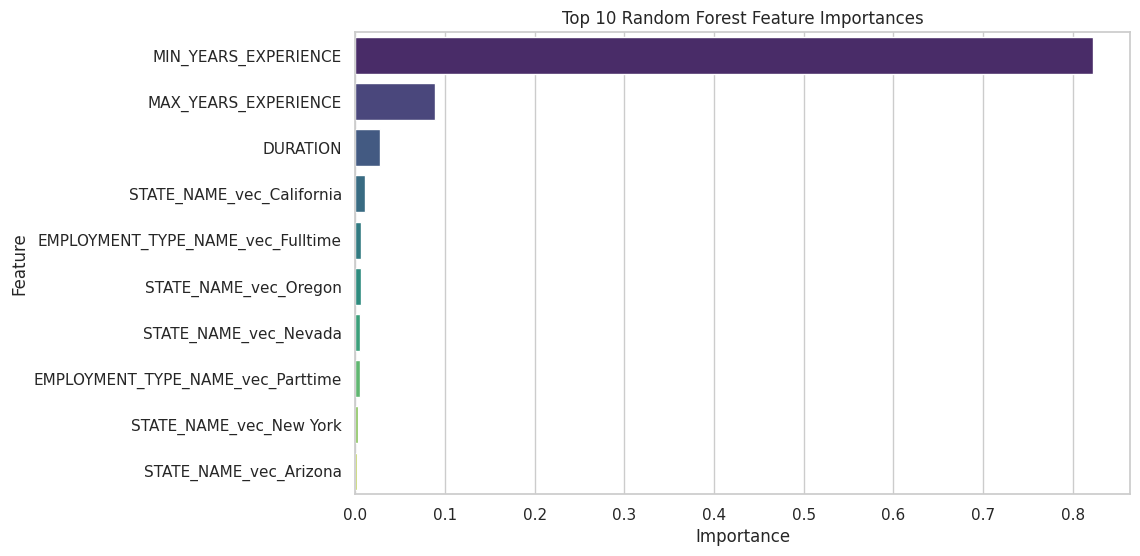

<Figure size 640x480 with 0 Axes>

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

importances = np.array(rf_model.featureImportances.toArray())

# Including the same features from the regression model excluding intercept
features = [f for f in features if f.lower() != "intercept"]


feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Top Feature Importances from Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("output/rf_feature_importance.png", dpi=300)
plt.show()

plt.savefig("output/rf_feature_importance.png", dpi=300)

The Random Forest model follows in alignment to the linear and polynomial regression models - clearly the years of experience have a significantly higher impact on the salary an employee makes.

Compare 3 Models – GLR, Polynomial, RF

Calculate RMSE, and AIC, BIC, for each model



In [67]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

poly_summary = poly_glr_max_years_model.summary

# --- Evaluate all three models ---
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
residuals_df = summary.predictions.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2))

# 1) GLR
glr_df = summary.predictions.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "GLR"})
glr_r2 = evaluator_r2.evaluate(summary.predictions)
glr_rmse = residuals_df.select(avg(col("squared_error")).alias("mse")).select(sqrt(col("mse")).alias("rmse")).collect()[0]["rmse"]
glr_aic = summary.aic
glr_bic = len(summary.coefficientStandardErrors) * np.log(summary.numInstances) + summary.numInstances * np.log(summary.deviance / summary.numInstances)


# 2) Polynomial
poly_df = poly_preds.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "Polynomial"})
poly_r2 = evaluator_r2.evaluate(poly_preds)
poly_rmse = np.sqrt(((poly_df["SALARY"] - poly_df["Polynomial"])**2).mean())
poly_aic = None  # Not available in LR
poly_bic = None 

# 3) RF
rf_df = rf_pred.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "RandomForest"})
rf_r2 = evaluator_r2.evaluate(rf_pred)
rf_rmse = np.sqrt(((rf_df["SALARY"] - rf_df["RandomForest"])**2).mean())
rf_aic = None
rf_bic = None

# Merge for plot
merged = glr_df.copy()
merged["Polynomial"] = poly_df["Polynomial"]
merged["RandomForest"] = rf_df["RandomForest"]

plot_df = merged.melt(id_vars="SALARY", var_name="Model", value_name="Predicted")
plot_df.head()    

,SALARY,Model,Predicted
0,15860.0,GLR,80744.393885
1,22440.0,GLR,103839.728424
2,22880.0,GLR,81701.846844
3,23179.0,GLR,90194.973966
4,23585.0,GLR,81212.374006


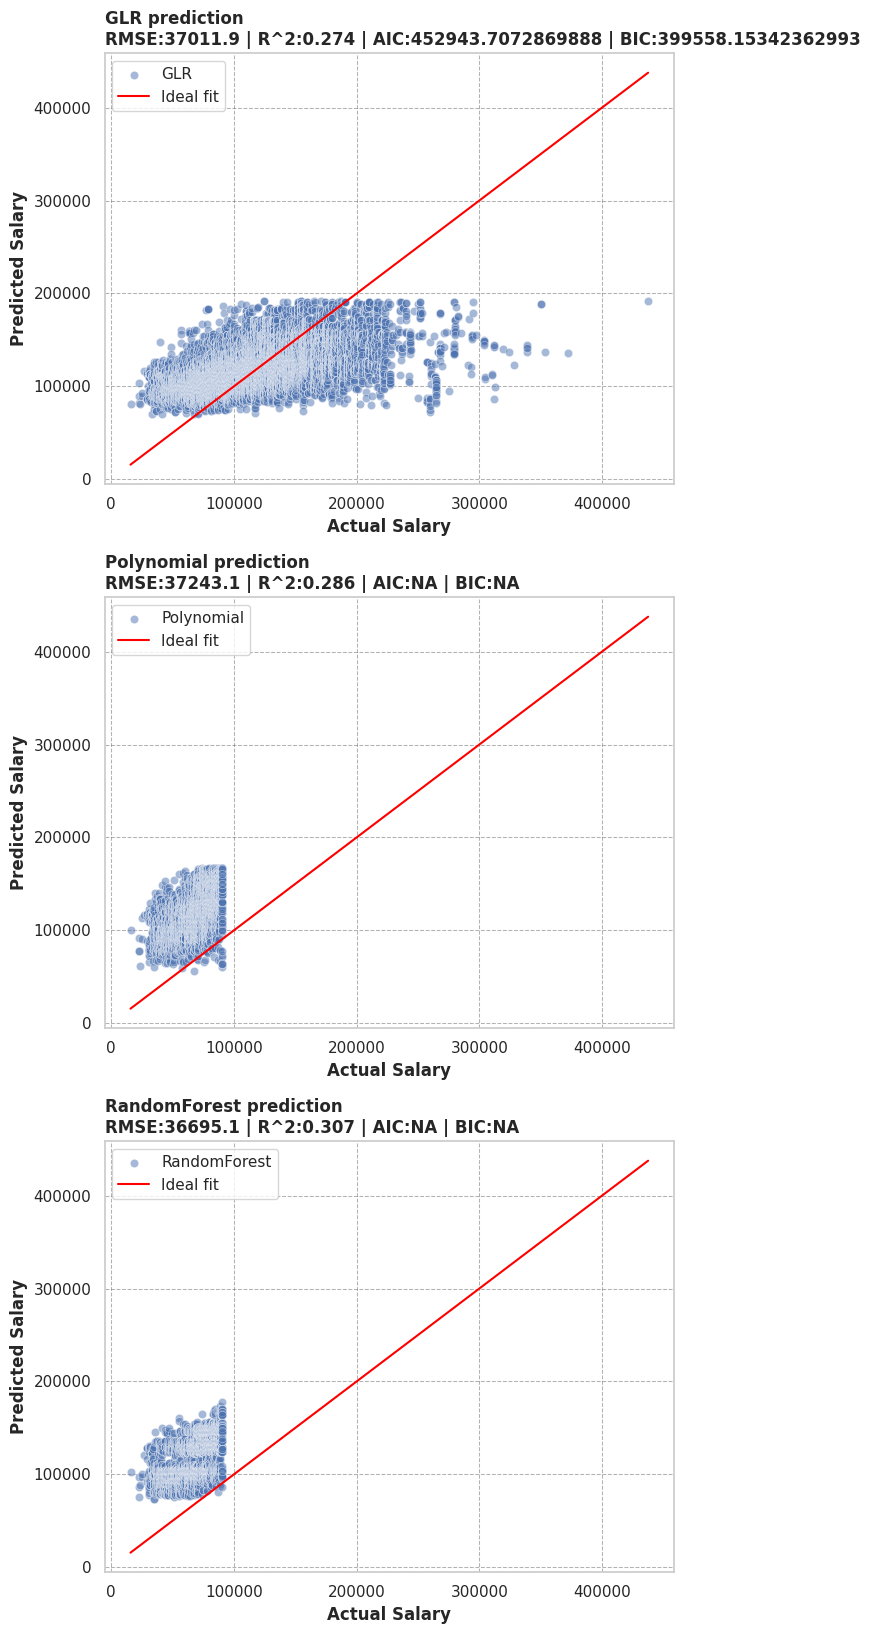

In [68]:
plt.figure(figsize=(7, 16.5))
sns.set_theme(style="whitegrid")

models = {
    "GLR": (glr_rmse, glr_r2, glr_aic, glr_bic),
    "Polynomial": (poly_rmse, poly_r2, "NA", "NA"),
    "RandomForest": (rf_rmse, rf_r2, "NA", "NA")
}

for idx, model in enumerate(models.keys(), 1):
    plt.subplot(3, 1, idx)
    temp_df = plot_df[plot_df["Model"] == model]
    sns.scatterplot(data=temp_df, x="SALARY", y="Predicted", alpha=0.5, label=model)
    sns.lineplot(x=temp_df["SALARY"], y=temp_df["SALARY"], color="red", label="Ideal fit")

    rmse, r2, aic, bic = models[model]

    plt.title(f"{model} prediction\nRMSE:{rmse:.1f} | R^2:{r2:.3f} | AIC:{aic} | BIC:{bic}", fontsize=12, fontweight='bold', loc='left')
    plt.xlabel("Actual Salary", fontsize=12, fontweight='bold')
    plt.ylabel("Predicted Salary", fontsize=12, fontweight='bold')

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.75, color='#676767')
    # plt.legend()

plt.tight_layout()
plt.savefig('output/final_model_2x2_comparison.png', dpi=300)
plt.show()
    
    

The R squared of the random forest in this case is the highest (albeit below 50%). The influence of salary using these variables is low, which further illustrates the point that the state in which an employee lives has low influence on the salary. Other categorical and numerical factors such as years experience, remote type, internship, etc. have more influence on the salary.